# <ins>Song Lyrics Through the Years</ins>

# Modeling

- In this notebook, I deal with outliers and build classification models using Naive Bayes, KNN, Decision Tree, Random Forest, SVM, and Doc2Vec.
- I also look at feature importances and confusion matrices to confirm my findings during EDA.
- I then tune and save a final model.

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Baseline model (Naive Bayes)](#Baseline-model-(Naive-Bayes))
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)
        - [Doc2Vec](#Doc2Vec)
        - [Parameter tuning](#Parameter-tuning)
        - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)
9. [Next notebook: Recommendation System](#Next-notebook:-Recommendation-System)

## Introduction

[[go back to the top](#Song-Lyrics-Through-the-Years)]

After [scraping](01_webscraping.ipynb) [Top 40 Weekly](https://top40weekly.com/) and [Genius](https://genius.com) for year-labeled song lyrics and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze song lyrics across decades.

In this notebook, I will create predictive models that classify songs into one of six decades: *1960s*, *1970s*, *1980s*, *1990s*, *2000s*, or *2010s*. This will help provide further insight and confirm my findings during EDA. *(To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

Since decades tend to kind of "bleed into each other", I anticipate a less-than-stellar classification model, but am excited by the prospect of using clustering techniques to create labels that aren't necessarily confined to a certain decade.

## The problem domain

[[go back to the top](#Song-Lyrics-Through-the-Years)]



## Required libraries

[[go back to the top](#Song-Lyrics-Through-the-Years)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scikit-learn**: The essential Machine Learning package in Python.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[modeling](functions/modeling.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: A package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [39]:
# custom functions for this project
from functions.modeling import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
from sklearn.feature_extraction.text import \
    TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, \
    cross_val_score
from sklearn.preprocessing import MinMaxScaler, \
    StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, \
    classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# miscellany
import time
from tqdm import tqdm
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Preparing the data

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [2]:
with gzip.open('data/lyrics_df_all_features.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['year', 'decade', 'title', 'artist', 'lyrics', 'lyrics_lined',
       'lyrics_no_artist', 'num_words', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'lyrics_lower', 'self_reference', 'lyrics_cleaned'],
      dtype='object')

In [4]:
# check out the class balance
df.decade.value_counts(normalize=True)

1960s    0.219137
1980s    0.203759
1970s    0.202050
1990s    0.146732
2000s    0.123452
2010s    0.104870
Name: decade, dtype: float64

- There is a decent enough class imbalance for me to consider correcting for that, using either downsampling or upsampling or possibly both.

### Multicollinearity

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [5]:
# list of continuous variables
cont_cols = [
    'num_words', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 'lexical_richness'
]

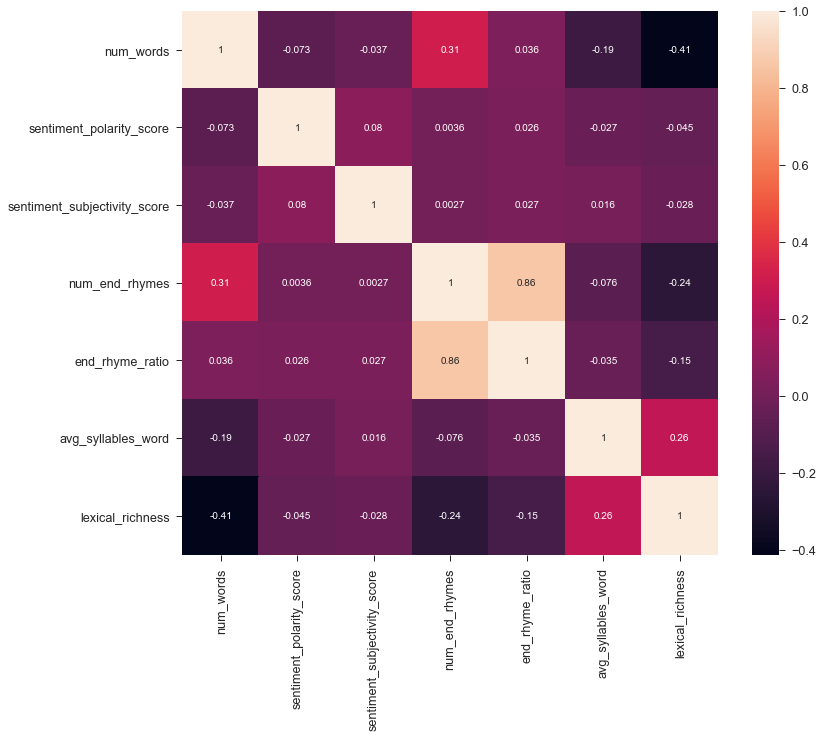

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- The number of end rhymes (```num_end_rhymes```) is highly correlated with ```end_rhyme_ratio```, so I'll drop ```num_end_rhymes``` in favor of what I believe is a more accurate measure of how "rhymey" a song is (i.e. ```end_rhyme_ratio```).
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [7]:
# new list of continuous variables
cont_cols = [
    'num_words', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'end_rhyme_ratio', 'avg_syllables_word', 'lexical_richness'
]

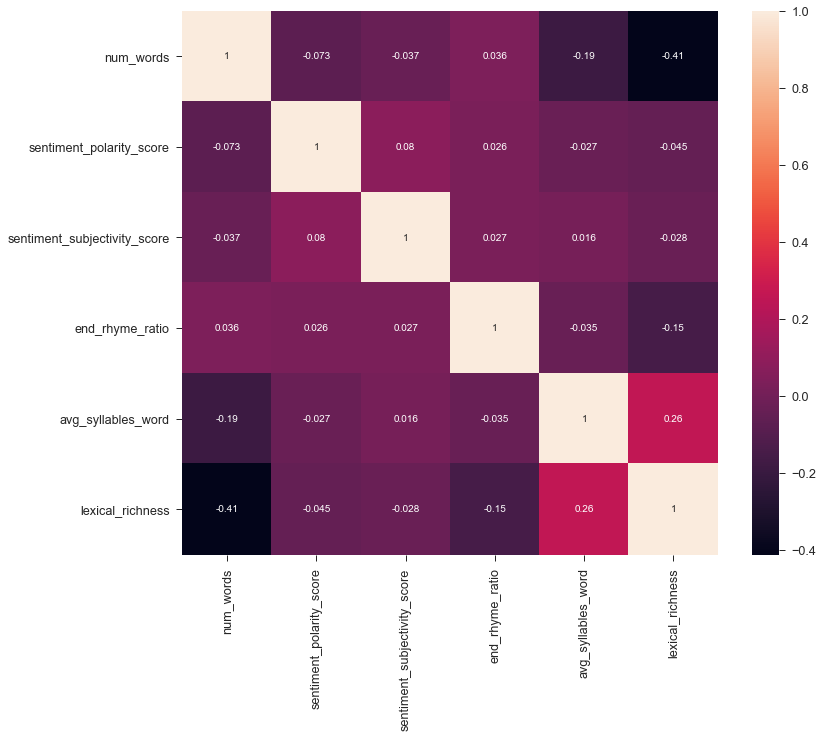

In [8]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Cap or floor outlier values as necessary.

In [9]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [10]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_words                       126.000000
sentiment_polarity_score         -0.989000
sentiment_subjectivity_score      0.296315
end_rhyme_ratio                   0.003451
avg_syllables_word                1.069556
lexical_richness                  0.195259
Name: 0.05, dtype: float64
------------------------------------------
num_words                       682.950000
sentiment_polarity_score          0.999300
sentiment_subjectivity_score      0.725017
end_rhyme_ratio                   0.451546
avg_syllables_word                1.294764
lexical_richness                  0.541390
Name: 0.95, dtype: float64


#### Number of words

In [11]:
# descriptive stats
df.num_words.describe()

count    4682.000000
mean      326.290901
std       174.813251
min        14.000000
25%       206.000000
50%       283.000000
75%       397.000000
max      1439.000000
Name: num_words, dtype: float64

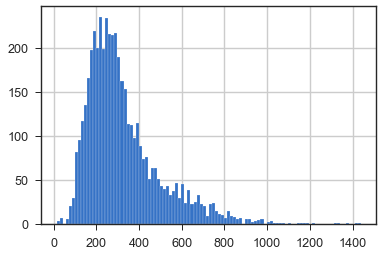

In [12]:
# current distribution
df.num_words.hist(bins=100);

In [13]:
# cap/floor outliers
df_capped['num_words'] = winsorizer(df['num_words'])

# descriptive stats
df_capped['num_words'].describe()

count    4682.000000
mean      320.774082
std       153.371417
min       126.000000
25%       206.000000
50%       283.000000
75%       397.000000
max       682.950000
Name: num_words, dtype: float64

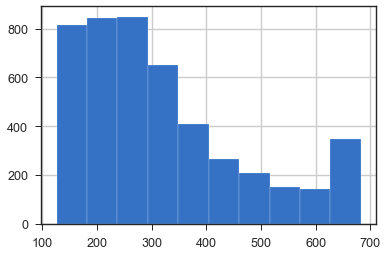

In [14]:
# new distribution
df_capped.num_words.hist();

#### End rhyme ratio

In [15]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4682.000000
mean        0.127856
std         0.189627
min         0.000000
25%         0.026801
50%         0.067450
75%         0.150545
max         2.915254
Name: end_rhyme_ratio, dtype: float64

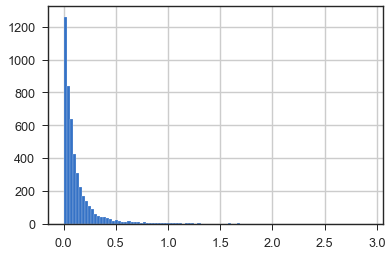

In [16]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [17]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4682.000000
mean        0.112350
std         0.120163
min         0.003451
25%         0.026801
50%         0.067450
75%         0.150545
max         0.451546
Name: end_rhyme_ratio, dtype: float64

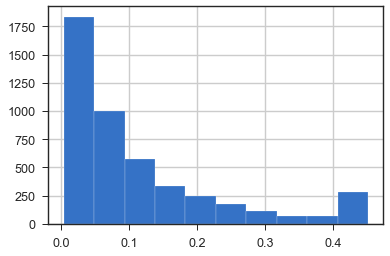

In [18]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [19]:
# descriptive stats
df.avg_syllables_word.describe()

count    4682.000000
mean        1.167500
std         0.072709
min         1.000000
25%         1.120147
50%         1.158537
75%         1.204585
max         2.500000
Name: avg_syllables_word, dtype: float64

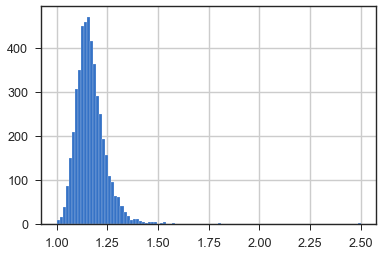

In [20]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [21]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4682.000000
mean        1.165498
std         0.060909
min         1.069556
25%         1.120147
50%         1.158537
75%         1.204585
max         1.294764
Name: avg_syllables_word, dtype: float64

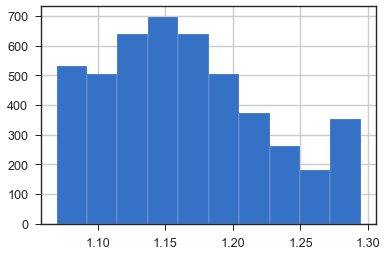

In [22]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [23]:
# descriptive stats
df.lexical_richness.describe()

count    4682.000000
mean        0.350012
std         0.106779
min         0.053571
25%         0.275421
50%         0.338105
75%         0.414488
max         0.894737
Name: lexical_richness, dtype: float64

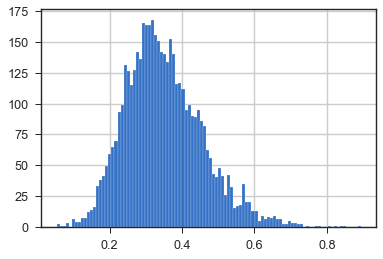

In [24]:
# current distribution
df.lexical_richness.hist(bins=100);

In [25]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4682.000000
mean        0.348159
std         0.095561
min         0.195259
25%         0.275421
50%         0.338105
75%         0.414488
max         0.541390
Name: lexical_richness, dtype: float64

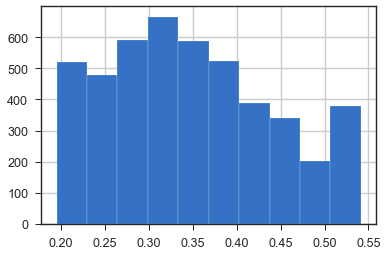

In [26]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [27]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4682.000000
mean        0.516232
std         0.132452
min         0.000000
25%         0.440237
50%         0.521374
75%         0.597288
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

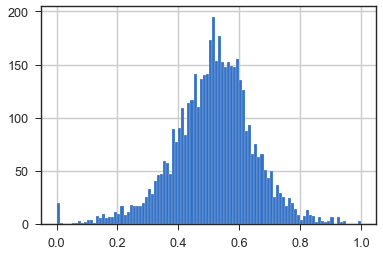

In [28]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [29]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(
    df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4682.000000
mean        0.517723
std         0.113635
min         0.296315
25%         0.440237
50%         0.521374
75%         0.597288
max         0.725017
Name: sentiment_subjectivity_score, dtype: float64

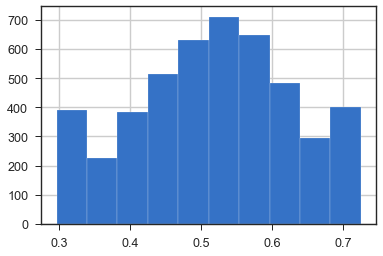

In [30]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [31]:
# uncomment to save
with gzip.open('data/lyrics_df_capped.pkl', 'wb') as goodbye:
    pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# uncomment to load
with gzip.open('data/lyrics_df_capped.pkl', 'rb') as hello:
    df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Create features DataFrame and target series.
    - While removing stop words was helpful for EDA in the [previous notebook](#03_nlp_features_eda.ipynb#Step-4:-Natural-language-processing), I'll refrain from doing that here, which should result in more accurate models. Using a TF-IDF vectorizer renders frequent words (i.e. words generally among the stop words list) less relevant.
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    - Vectorize using a TF-IDF vectorizer.
    
#### Features and target

In [32]:
df_capped.columns

Index(['year', 'decade', 'title', 'artist', 'lyrics', 'lyrics_lined',
       'lyrics_no_artist', 'num_words', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'lyrics_lower', 'self_reference', 'lyrics_cleaned'],
      dtype='object')

In [33]:
# create features dataframe
X = df_capped[
    ['num_words', 'sentiment_polarity_score', 'sentiment_subjectivity_score',
     'end_rhyme_ratio', 'avg_syllables_word', 'lexical_richness', 'self_reference']
]

# assign target variable
y = df_capped['decade']

In [34]:
# list of classes that will be useful for graphs later
classes = df.decade.unique()

In [40]:
# lowercase text without punctuation and contractions
X['string_processed'] = df_capped.lyrics_cleaned.apply(
    simple_process)

In [41]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3511, 8)
Test shape (rows, columns): (1171, 8)


#### Scale numerical data

In [42]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_processed')
X_test_nums = X_test.drop(columns='string_processed')

In [43]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                                 columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [44]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and 
# transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(
    X_train.string_processed)
X_test_vec_matrix = vectorizer.transform(
    X_test.string_processed)

CPU times: user 412 ms, sys: 4.72 ms, total: 417 ms
Wall time: 417 ms


In [45]:
%%time

# convert tf-idf vectors into dataframe so I can better view 
# feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(
    X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(
    X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 9.11 s, sys: 31.1 ms, total: 9.14 s
Wall time: 9.15 s


In [46]:
X_train_vec.shape, X_test_vec.shape

((3511, 17773), (1171, 17773))

### Combo DataFrame

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [47]:
# combine the numerical and vector dataframes for both 
# train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], 
                          axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], 
                         axis=1)

# Step 2: Modeling

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters on the best model.
- Finally, I can train and save a final model.

## Baseline model (Naive Bayes)

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [48]:
%%time

# instantiate classifier
benaba_vec = BernoulliNB()

# fit it to training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 2.07 s, sys: 327 ms, total: 2.4 s
Wall time: 2.2 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [49]:
%%time

# model predictions and printout
train_preds_bnb_vec, test_preds_bnb_vec = \
    predict(
        benaba_vec, 
        X_train_vec, y_train, 
        X_test_vec, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6445457134719453
F1 score: 0.6237429359075474

-----TEST-----
Accuracy: 0.42442356959863364
F1 score: 0.3812694608405662

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

       1960s       0.50      0.80      0.62       257
       1970s       0.35      0.26      0.30       236
       1980s       0.33      0.60      0.43       239
       1990s       0.42      0.06      0.11       172
       2000s       0.53      0.42      0.47       144
       2010s       0.94      0.14      0.24       123

    accuracy                           0.42      1171
   macro avg       0.51      0.38      0.36      1171
weighted avg       0.48      0.42      0.38      1171


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[205  24  26   1   1   0]
 [102  61  69   2   2   0]
 [ 50  41 143   3   2   0]
 [

- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [50]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            classes
        )

1960S:
aaa, nuisance, null, numbed, numbin, numbness, numbs, nunca, nursing, nut

1970S:
aaa, noopy, noose, norm, norma, normal, normally, northeast, northern, northside

1980S:
aaa, nuthin, nutsack, nuttin, nutty, nuttynuttynutty, nutz, nuvo, nwod, nword

1990S:
aaa, negative, negatte, nei, neighbourhood, neiman, nein, nekkid, nel, nell

2000S:
aaa, naona, napo, naraba, narc, narrabeen, narrow, narrowminded, narudi, nascar

2010S:
zwei, israel, israelite, somethins, issexy, isso, issosodef, somethi, ist, isotoners



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

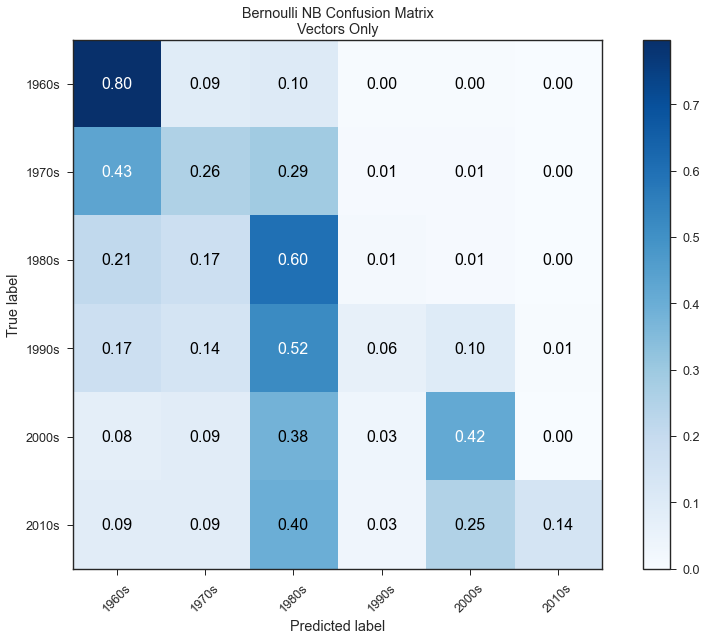

In [52]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_vec)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,                   
    title='Bernoulli NB Confusion Matrix\nVectors Only', 
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_vec_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [53]:
%%time

# instantiate classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 4.91 s, sys: 917 ms, total: 5.83 s
Wall time: 5.59 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [54]:
%%time

# model predictions and printout
train_preds_bnb_combo, test_preds_bnb_combo = \
    predict(
        benaba_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.643976075192253
F1 score: 0.6228251227427967

-----TEST-----
Accuracy: 0.4269854824935952
F1 score: 0.3833242710345822

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

       1960s       0.50      0.79      0.62       257
       1970s       0.36      0.25      0.30       236
       1980s       0.33      0.62      0.43       239
       1990s       0.44      0.06      0.11       172
       2000s       0.54      0.42      0.47       144
       2010s       0.94      0.14      0.24       123

    accuracy                           0.43      1171
   macro avg       0.52      0.38      0.36      1171
weighted avg       0.48      0.43      0.38      1171


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[204  23  28   1   1   0]
 [101  60  71   2   2   0]
 [ 48  39 147   3   2   0]
 [ 3

- Practically the same result; a very slight boost if anything.

#### Confusion matrix

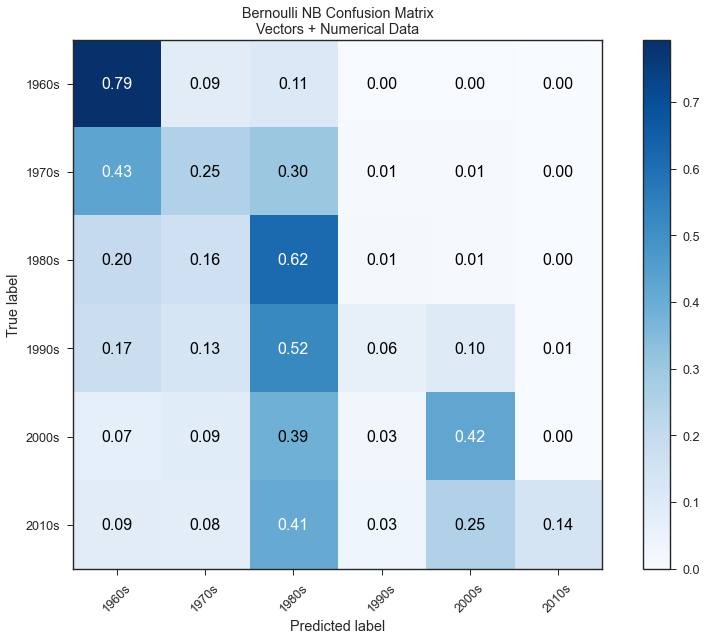

In [55]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Bernoulli NB Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_combo_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- This confirms it is practically the same result.

#### Feature importances

In [56]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            classes
        )

1960S:
zwei, knocker, knockinem, knockkneed, spumante, spud, sprung, spruce, knowhatimsayin, knowhows

1970S:
lieux, nooooo, noooooo, noopy, noose, norm, norma, normal, normally, northeast

1980S:
lieux, layer, layin, layla, layodlayodlayhehoo, layodlayodlow, stroller, lbc, lchaim, strokin

1990S:
lieux, negative, negatte, nei, neighbourhood, neiman, nein, nekkid, nel, nell

2000S:
lieux, nanilii, nann, naona, napo, naraba, narc, narrabeen, narrow, narrowminded

2010S:
lieux, nicht, nickelnine, nickelodeon, nico, nicoles, nicolo, nida, nieb, niece



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [57]:
# instantiate classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

⏰ *NOTE: The next cell took me about 5 minutes to run.*

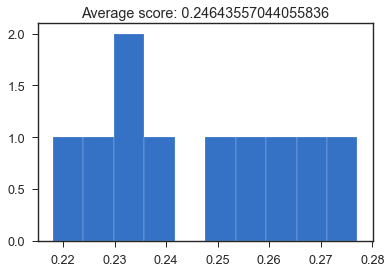

CPU times: user 55.9 s, sys: 1.03 s, total: 56.9 s
Wall time: 2min 20s


In [58]:
%%time

# vectors only model
cv_scores = cv_plotter(knn_vec, X_train_vec, y_train)

⏰ *NOTE: The next cell took me about 6 minutes to run.*

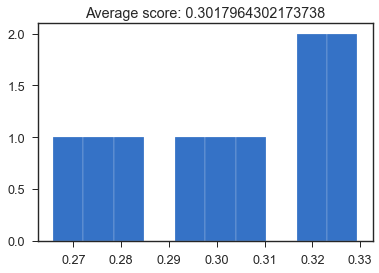

CPU times: user 57.3 s, sys: 933 ms, total: 58.3 s
Wall time: 2min 35s


In [59]:
%%time

# combo model
cv_scores = cv_plotter(knn_combo, X_train_combo, y_train)

- The combo data set performs better than the Naive Bayes model and far better than the vectors only set.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

⏰ *NOTE: The next cell took me about 15 minutes to run.*

100%|██████████| 10/10 [06:09<00:00, 36.94s/it]


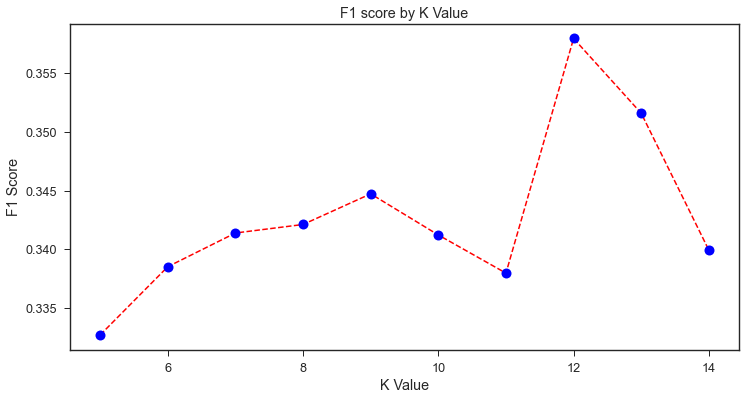

CPU times: user 33min 31s, sys: 17.2 s, total: 33min 48s
Wall time: 6min 9s


In [60]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
# use at least 5 neighbors since there are 4 classes
k_range = list(range(5, 15))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [63]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 5)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(12, 0.3579265740615948),
 (13, 0.3515685265503856),
 (9, 0.34471693258468233),
 (8, 0.3421113776984103),
 (7, 0.3413876343070625)]

- After all that, the default of *k=12* appears to have the best results, so I'll train a model on that.

In [64]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=12, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 6.95 s, sys: 797 ms, total: 7.74 s
Wall time: 7.75 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')

⏰ *NOTE: The next cell took me about 5 minutes to run.*

In [65]:
%%time

# model predictions and printout
train_preds_knn_combo, test_preds_knn_combo = \
    predict(
        knn_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.4642551979493022
F1 score: 0.45686028105848914

-----TEST-----
Accuracy: 0.36037574722459437
F1 score: 0.3579265740615948

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

       1960s       0.44      0.49      0.46       257
       1970s       0.31      0.32      0.32       236
       1980s       0.31      0.35      0.33       239
       1990s       0.32      0.33      0.32       172
       2000s       0.41      0.38      0.40       144
       2010s       0.42      0.21      0.28       123

    accuracy                           0.36      1171
   macro avg       0.37      0.35      0.35      1171
weighted avg       0.36      0.36      0.36      1171


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[125  67  45  14   3   3]
 [ 70  76  55  25   8   2]
 [ 50  46  84  39  12   8]
 

#### Confusion matrix

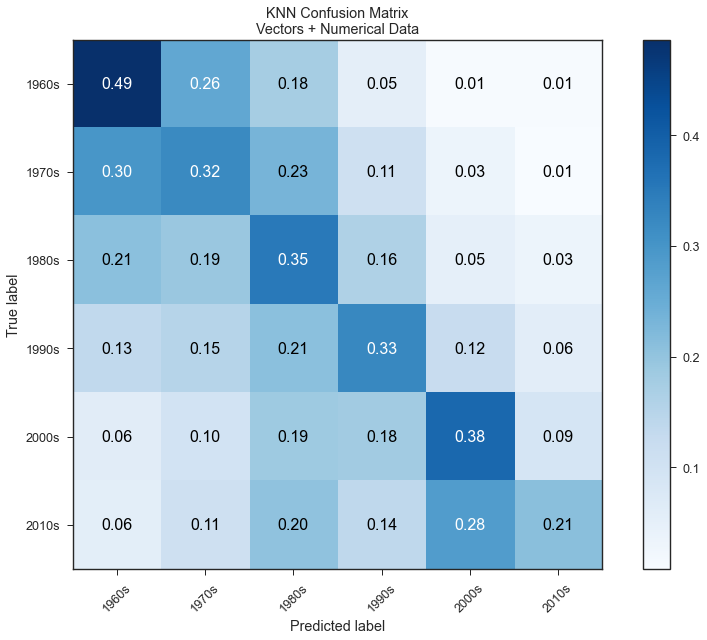

In [66]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_knn_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='KNN Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/knn_combo_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Avant-Garde, which is interesting. Perhaps this genre is quite clustered, as is Pre-1900 poetry.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Metropolitan and Modern poetries.
    
- Pretty overfit.

## Decision Tree

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [67]:
# instantiate classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

⏰ *NOTE: The next cell took me about 3 minutes to run.*

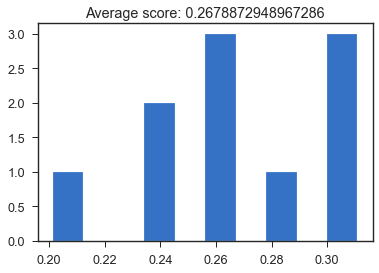

CPU times: user 42.9 s, sys: 689 ms, total: 43.6 s
Wall time: 58 s


In [68]:
%%time

# vectors only model
cv_scores = cv_plotter(tree_vec, X_train_vec, y_train)

⏰ *NOTE: The next cell took me about 3 minutes to run.*

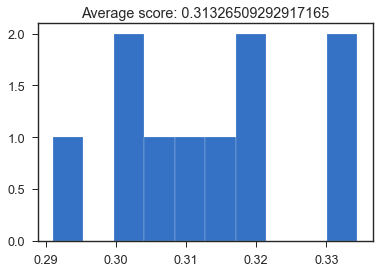

CPU times: user 44.5 s, sys: 603 ms, total: 45.1 s
Wall time: 1min 1s


In [69]:
%%time

# combo model
cv_scores = cv_plotter(tree_combo, X_train_combo, y_train)

- A Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain those using Random Forest, however.

## Random Forest

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

In [70]:
# instantiate classifiers
forest_vec = RandomForestClassifier(random_state=42)
forest_combo = RandomForestClassifier(random_state=42)

⏰ *NOTE: The next cell took me about 3 minutes to run.*

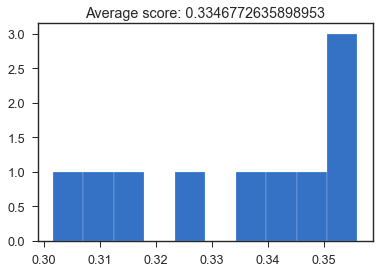

CPU times: user 48 s, sys: 504 ms, total: 48.5 s
Wall time: 1min 12s


In [71]:
%%time

# vectors only model
cv_scores = cv_plotter(forest_vec, X_train_vec, y_train)

⏰ *NOTE: The next cell took me about 4 minutes to run.*

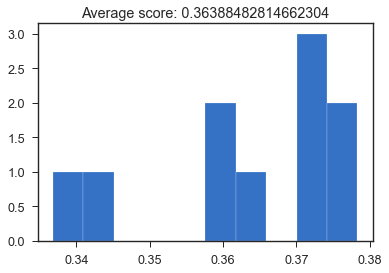

CPU times: user 49.8 s, sys: 575 ms, total: 50.4 s
Wall time: 1min 18s


In [72]:
%%time

# combo model
cv_scores = cv_plotter(forest_combo, X_train_combo, y_train)

- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [73]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=42)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 13.1 s, sys: 675 ms, total: 13.8 s
Wall time: 13.8 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [74]:
%%time

# model predictions and printout
train_preds_forest_combo, test_preds_forest_combo = \
    predict(
        forest_combo,
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.4022203245089667
F1 score: 0.37611258513869195

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

       1960s       0.48      0.74      0.58       257
       1970s       0.31      0.31      0.31       236
       1980s       0.32      0.47      0.39       239
       1990s       0.33      0.10      0.16       172
       2000s       0.47      0.38      0.42       144
       2010s       0.79      0.19      0.30       123

    accuracy                           0.40      1171
   macro avg       0.45      0.37      0.36      1171
weighted avg       0.43      0.40      0.38      1171


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[190  37  28   0   2   0]
 [101  72  55   6   1   1]
 [ 57  55 113  10   4   0]
 [ 25  30  79  18  19   1]
 [ 16

#### Confusion matrix

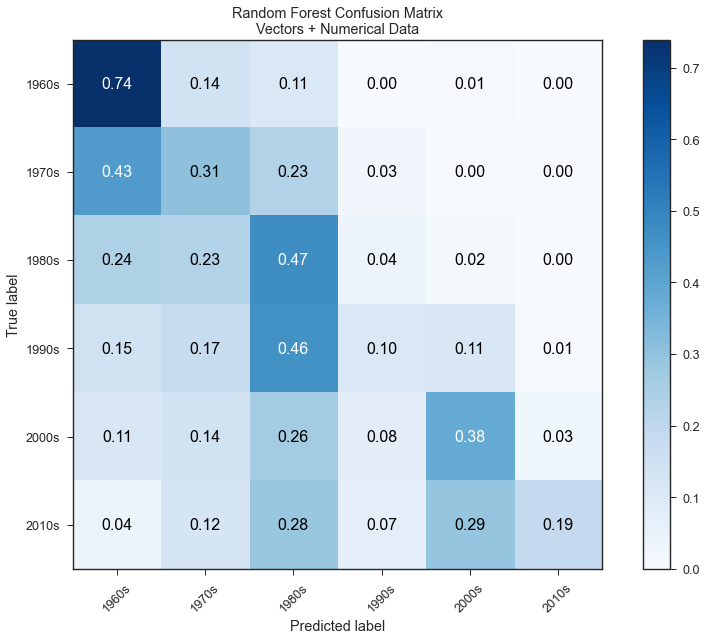

In [75]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_forest_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Random Forest Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/rf_combo_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- Much better overall F1 score, but I'm back to overpredicting Modern.
- Unlike KNN, however, this is very overfit, so tuning this would definitely be necessary.
- Still, this will be a great model to use to look at important features.

#### Feature importances

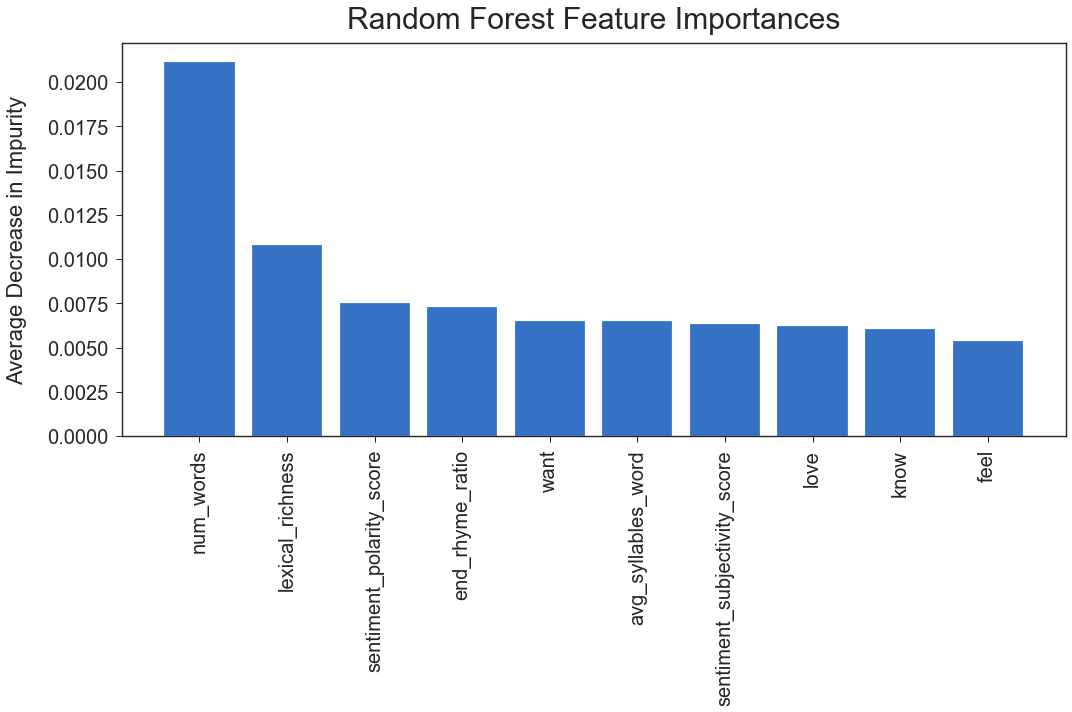

In [76]:
# top 10 features
plot_forest_features(
    forest_combo, 
    X_train_combo,
    to_print=False
)

- Mostly engineered features here, with the ratio of end rhymes to total lines have a large importance compared to the rest.
- Also, stop words seem important, perhaps meaning that some movements use more stop words than others.

## SVM

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [77]:
# instantiate classifiers
svm_vec = LinearSVC(random_state=42)
svm_combo = LinearSVC(random_state=42)

⏰ *NOTE: The next cell took me about 2 minutes to run.*

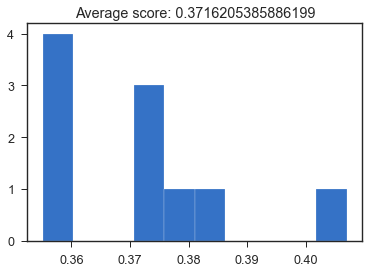

CPU times: user 41.2 s, sys: 454 ms, total: 41.6 s
Wall time: 53.6 s


In [78]:
%%time

# vectors only model
cv_scores = cv_plotter(svm_vec, X_train_vec, y_train)

⏰ *NOTE: The next cell took me about 8 minutes to run.*

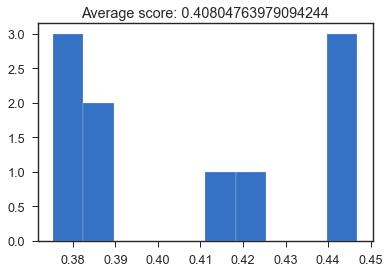

CPU times: user 50.1 s, sys: 579 ms, total: 50.6 s
Wall time: 1min 19s


In [79]:
%%time

# combo model
cv_scores = cv_plotter(svm_combo, X_train_combo, y_train)

- This is the best one yet! And I'm not surprised. SVM tends to work well with text classification and data that has fewer data points and lots of variables (i.e. sparse word vectors).
- Once again, my engineered features seem to help out the model, so I'll train a basic one here. Then I can focus on tuning parameters.

### Vectors + numerical data

In [80]:
%%time

# instantiate the model
svm_combo = LinearSVC(random_state=42)

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 11.6 s, sys: 725 ms, total: 12.3 s
Wall time: 12.3 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [81]:
%%time

# model predictions and printout
train_preds_svm_combo, test_preds_svm_combo = \
    predict(
        svm_combo, 
        X_train_combo, y_train, 
        X_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.952435203645685
F1 score: 0.9524110769061687

-----TEST-----
Accuracy: 0.4218616567036721
F1 score: 0.41984983581048435

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

       1960s       0.54      0.55      0.55       257
       1970s       0.39      0.36      0.38       236
       1980s       0.38      0.43      0.40       239
       1990s       0.31      0.27      0.29       172
       2000s       0.44      0.49      0.46       144
       2010s       0.46      0.38      0.42       123

    accuracy                           0.42      1171
   macro avg       0.42      0.41      0.41      1171
weighted avg       0.42      0.42      0.42      1171


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[142  64  36  10   3   2]
 [ 63  86  48  27   7   5]
 [ 35  42 102  30  18  12]
 [ 

#### Confusion matrix

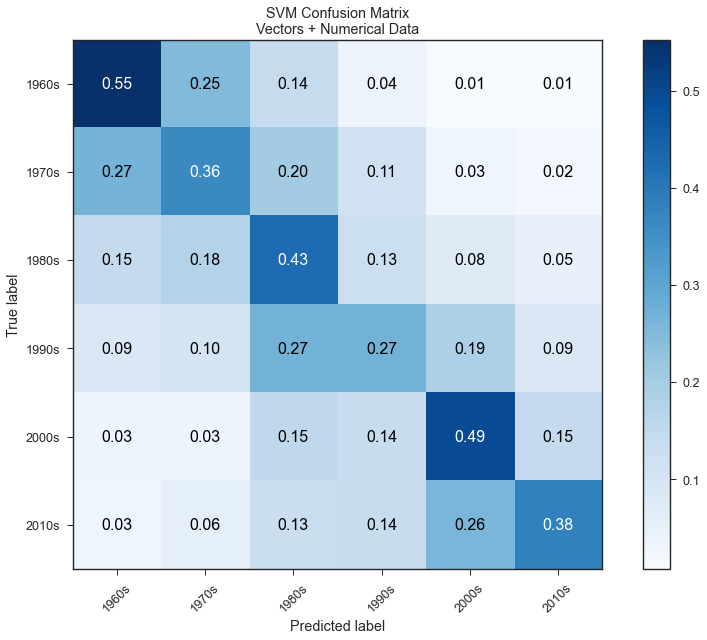

In [82]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_combo)

# plot as graph
plot_confusion_matrix(
    cm, 
    classes,
    normalize=True,
    title='SVM Confusion Matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_combo_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- Still very overfit but a good spread of predictions here compared to the other models.
    - Each category is correctly predicted at least half the time.
- Pre-1900 poetry is very easily recognized by the model.
    - Modern poetry appears to be the largest confusing factor here, so must share some similarities with Pre-1900 poetry. 
    - Avant-Garde and Metropolitan are hardly ever predicted for Pre-1900 poems, and Pre-1900 is hardly predicted for Metropolitan and Avant-Garde poems.
- As in the KNN, Avant-Garde has seen quite a boost, whereas Avant-Garde and Modern seem a little more difficult to correctly predict.

#### Feature importances

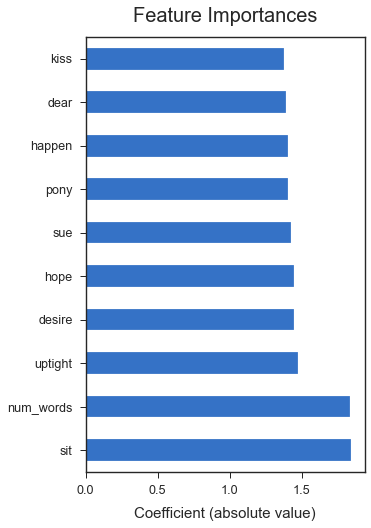

In [83]:
# top 10 features
svm_features(svm_combo, X_train_combo.columns)

- Only the ratio of end rhymes to total lines made it from my engineered features. 
- Mostly surprising words, *white* being the only word in the top 25 overall.

## Doc2Vec

[[go back to the top](#Song-Lyrics-Through-the-Years)]

#### Important note
- Due to the randomness involved in creating document vectors, results here may end up being slightly different. By setting epochs to 100, I've found that this is fairly stable, although the best values for *C* within the SVM models later on will vary slightly with subsequent iterations.

### Preparing the data
- Instead of using the MinMaxScaler, I'll rescale my engineered features using StandardScaler, since the document vectors appear to be more along that scale.
- Then I'll split the poems into a training and a testing corpus and create TaggedDocument objects needed by Doc2Vec, using only the training data.

In [78]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                                 columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                columns=X_test_nums.columns)

In [79]:
# for train-test split
train_data = [poem.split() for poem in X_train.string_processed]
test_data = [poem.split() for poem in X_test.string_processed]

# prepare training data in doc2vec format
train_docs = [TaggedDocument((d), tags=[i]) \
              for i, d in enumerate(train_data)]

### Training a model
- I'll train the model on the training data and create vectors using the model for *both* the train set and the test set, which tends to prevent overfitting.
- After combining with my engineered features, I'll cross validate and train a model.
- Much of this code is based on O'Reilly's [Practical NLP](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/02_Doc2Vec_Example.ipynb).

⏰ *NOTE: The next cell took me about 1 minute to run.*

In [80]:
%%time

# train a doc2vec model, using only training data
model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

CPU times: user 2min 3s, sys: 3.32 s, total: 2min 6s
Wall time: 56.3 s


#### Important note
- To use my original Doc2Vec (document vectors) model, uncomment ```model = Doc2Vec.load('data/d2v.model')``` below.
- Otherwise, due to randomness in the algorithm, results will different, though should be fairly similar.

In [81]:
# # uncomment to save model
# model.save('data/doc2vec_training.model')

# # uncomment to load model
# model = Doc2Vec.load('data/doc2vec_training.model')

⏰ *NOTE: The next cell took me about 2 minutes to run.*

In [82]:
%%time

# infer in multiple steps to get a stable representation 
train_vecs = [model.infer_vector(words, epochs=100) \
              for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) \
             for words in test_data]

CPU times: user 1min 45s, sys: 142 ms, total: 1min 45s
Wall time: 1min 45s


In [83]:
# convert both sets to dataframe
doc_train_vec = pd.DataFrame(train_vecs, columns=[
    f'docvec_{i}' for i in range(1,101)
])

doc_test_vec = pd.DataFrame(test_vecs, columns=[
    f'docvec_{i}' for i in range(1,101)
])

In [84]:
# combine with engineered features
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vec], 
                            axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vec], 
                           axis=1)

# confirm good shape
doc_train_combo.shape, doc_test_combo.shape

((3230, 107), (1077, 107))

In [85]:
# instantiate classifiers
svm_doc_vec = LinearSVC(random_state=42)
svm_doc_combo = LinearSVC(random_state=42)

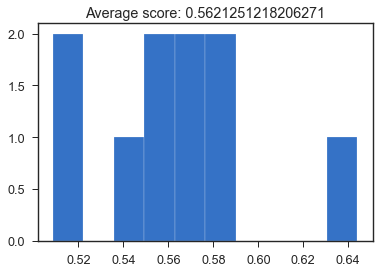

CPU times: user 171 ms, sys: 33.5 ms, total: 204 ms
Wall time: 7.9 s


In [86]:
%%time

# vectors only model
cv_scores = cv_plotter(svm_doc_vec, doc_train_vec, y_train)

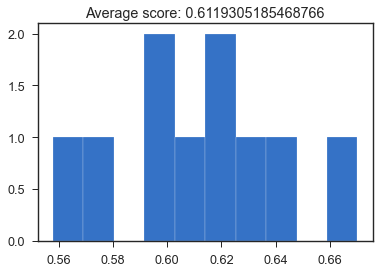

CPU times: user 157 ms, sys: 8.76 ms, total: 166 ms
Wall time: 8.02 s


In [87]:
%%time

# combo model
cv_scores = cv_plotter(svm_doc_combo, doc_train_combo, y_train)

- Once again, the combination of vectors and engineered features provides better F1 scores.

In [88]:
%%time

# instantiate the model
svm_doc_combo = LinearSVC(C=1, random_state=42)

# fit to the training set
svm_doc_combo.fit(doc_train_combo, y_train)

CPU times: user 2.64 s, sys: 5.43 ms, total: 2.64 s
Wall time: 2.64 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [89]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc = \
    predict(
        svm_doc_combo, 
        doc_train_combo, y_train, 
        doc_test_combo, y_test, 
        classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.6585139318885449
F1 score: 0.656869038874977

-----TEST-----
Accuracy: 0.5970287836583101
F1 score: 0.5884128576995944

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.55      0.50      0.53       239
metropolitan       0.47      0.71      0.57       268
      modern       0.64      0.36      0.46       311
    pre_1900       0.80      0.85      0.82       259

    accuracy                           0.60      1077
   macro avg       0.61      0.61      0.59      1077
weighted avg       0.62      0.60      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[120  89  24   6]
 [ 52 191  20   5]
 [ 43 110 113  45]
 [  3  18  19 219]]
CPU times: user 180 ms, sys: 26 ms, total: 206 ms
Wall time: 53 ms


#### Confusion matrix

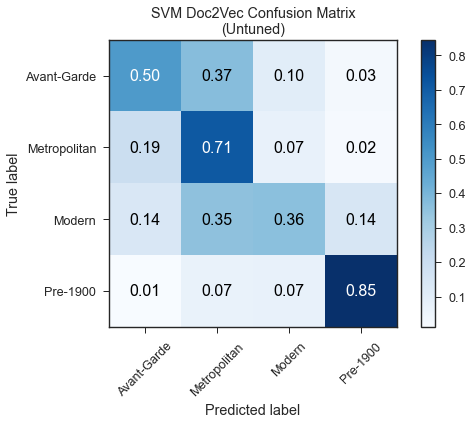

In [90]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM Doc2Vec Confusion Matrix\n(Untuned)',
    cmap=plt.cm.Blues)

# # # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- Interestingly tends to overpredict on Avant-Garde and has a difficult time correctly identifying Modern poetry.
- Incredible score for Pre-1900 poetry.

#### Feature importances

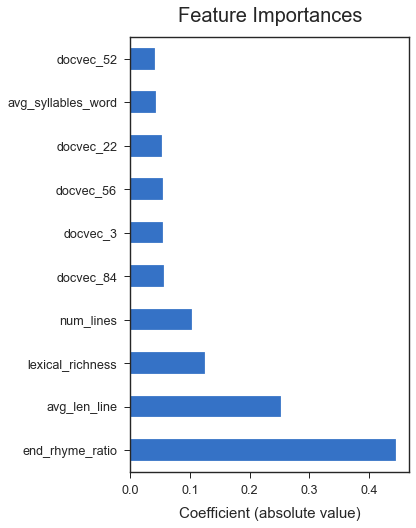

In [91]:
# top 10 features
svm_features(svm_doc_combo, doc_train_combo.columns)

- This certainly brings my engineered features back to the forefront, with those being five out of the top ten features. The only ones not here are sentiment scores (polarity and subjectivity).
- Unfortunately, the rest of the features, being dimensions within the model, are rather enigmatic.

#### Moving forward with SVM Doc2Vec model
- While the F1 scores are worse for the document vectors (as opposed to the TF-IDF vectors), the fit is overwhelmingly better, so it should generalize better on unseen data. I'll move ahead with this simpler version, which will also be easier to implement into a recommendation system.
- Before that, I'll look into tuning the model's parameters by using GridSearchCV.

## Parameter tuning

[[go back to the top](#Song-Lyrics-Through-the-Years)]

#### Finding the best value for *C* using GridSearchCV.

In [92]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

In [93]:
doc_grid = GridSearchCV(LinearSVC(random_state=42), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [94]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [95]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6304319745208897
{'C': 0.01}
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


#### Note
- After achieving some less than stellar results for this tuning, I did some trial and error and came up with value for *C* with a much better F1 score.
- Farther down, I confirm that it is a decent value by cross validating and finding that the score is only less than 0.4% less accurate with my trial-and-error value.
- The spread of the predictions is also far preferable with a lower *C* value.

In [96]:
%%time

# instantiate the model
svm_doc_tuned = LinearSVC(C=0.00125, random_state=42)

# fit to the training set
svm_doc_tuned.fit(doc_train_combo, y_train)

CPU times: user 109 ms, sys: 831 µs, total: 110 ms
Wall time: 109 ms


LinearSVC(C=0.00125, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [97]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc_tuned = \
    predict(svm_doc_tuned, doc_train_combo, y_train, 
            doc_test_combo, y_test, classes=sorted(y.unique()))

-----TRAIN-----
Accuracy: 0.673374613003096
F1 score: 0.670098577508811

-----TEST-----
Accuracy: 0.6443825441039925
F1 score: 0.6386681920981394

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.59      0.51      0.55       239
metropolitan       0.57      0.67      0.61       268
      modern       0.62      0.52      0.57       311
    pre_1900       0.79      0.89      0.84       259

    accuracy                           0.64      1077
   macro avg       0.64      0.65      0.64      1077
weighted avg       0.64      0.64      0.64      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[121  66  45   7]
 [ 47 179  33   9]
 [ 37  64 163  47]
 [  0   6  22 231]]
CPU times: user 180 ms, sys: 26.3 ms, total: 207 ms
Wall time: 53.2 ms


#### Confusion matrix

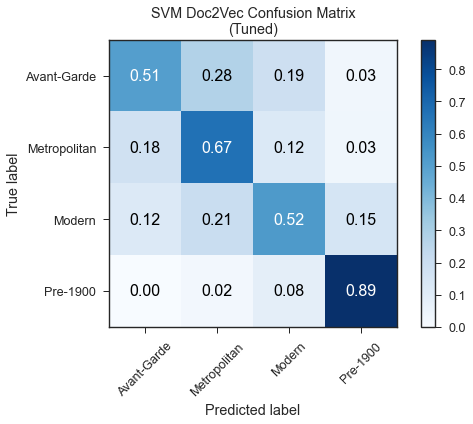

In [98]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc_tuned)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM Doc2Vec Confusion Matrix\n(Tuned)',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_tuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- Every movement now has an accuracy of at least 50%, and an F1 score of at least 55%.
- Pre-1900 remains very easily identified, and Metropolitan performs better than the other two remaining movements.
- Also this is a very well-fit model comparatively.
- I'll check if there have been any changes to feature importances.

#### Feature importances

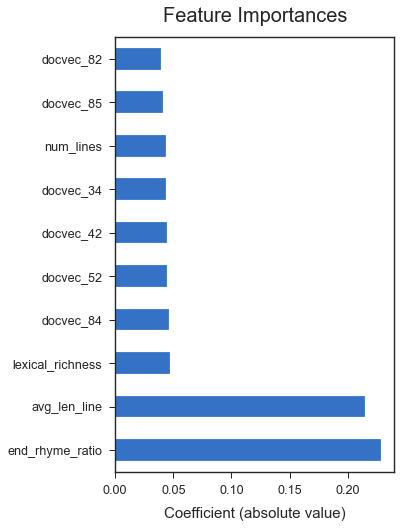

In [99]:
# top 10 features
svm_features(svm_doc_tuned, doc_train_combo.columns)

- Average syllables per word has fallen out of the top 10.
- Number of lines has dropped down a bit.

#### Cross validation confirmation from earlier note

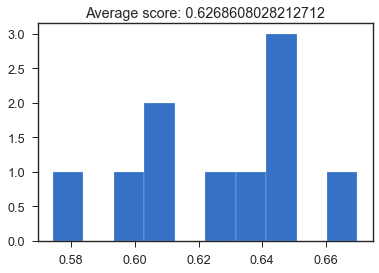

CPU times: user 161 ms, sys: 8.18 ms, total: 170 ms
Wall time: 525 ms


In [100]:
%%time

# combo model
cv_scores_tuned = cv_plotter(
    svm_doc_tuned, doc_train_combo, y_train)

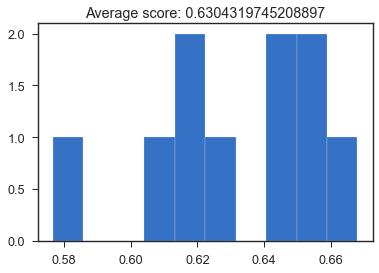

CPU times: user 150 ms, sys: 6.95 ms, total: 157 ms
Wall time: 1.91 s


In [101]:
%%time

# combo model
cv_scores_grid = cv_plotter(
    doc_grid.best_estimator_, 
    doc_train_combo, 
    y_train)

## Train final model

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I'll train a final model on all the data and save.

#### Prepare data

In [102]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical data (slicing off processed string)
X_scaled = scaler.fit_transform(X.iloc[:,:-1])

# convert array to dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=X.iloc[:,:-1].columns)

In [103]:
# list of words in each poem
poem_words = [poem.split() for poem in X.string_processed]

# prepare training data in doc2vec format
docs = [TaggedDocument((d), tags=[i]) \
        for i, d in enumerate(poem_words)]

#### Train model

⏰ *NOTE: Next cell took me about 1 minute to run.*

In [104]:
%%time

# train a doc2vec model, using all data
final_model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

final_model.build_vocab(docs)
final_model.train(
    docs, 
    total_examples=final_model.corpus_count, 
    epochs=final_model.epochs)

CPU times: user 2min 49s, sys: 4.33 s, total: 2min 54s
Wall time: 1min 16s


#### Important note
- To use my original classification model (trained on all that data), uncomment ```final_model = Doc2Vec.load('data/d2v_final.model')``` below.

In [105]:
# # uncomment to save model
# final_model.save('data/doc2vec_final.model')

# # uncomment to load model
# final_model = Doc2Vec.load('data/doc2vec_final.model')

⏰ *NOTE: The next cell took me about 2 minutes to run.*

In [106]:
%%time

# infer in multiple steps to get a stable representation
vecs = [final_model.infer_vector(words, epochs=100) \
        for words in poem_words]

CPU times: user 1min 56s, sys: 128 ms, total: 1min 56s
Wall time: 1min 56s


In [107]:
# convert to dataframe
doc_vec = pd.DataFrame(vecs, columns=[
    f'docvec_{i}' for i in range(1,101)
])

# combine with engineered features
doc_combo = pd.concat([X_scaled_df, doc_vec], axis=1)

# confirm good shape
doc_combo.shape

(4307, 107)

#### 💾 Save/Load the final DataFrame

In [118]:
# # uncomment to save
# with gzip.open('data/features_doc2vec_df.pkl', 'wb') as goodbye:
#     pickle.dump(doc_combo, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/features_doc2vec_df.pkl', 'rb') as hello:
#     doc_combo = pickle.load(hello)

### Evaluate
- The *C* value recommended during the GridSearch earlier actually works better when training on the full set!
- It goes to show that there is a lot of variability when using Doc2Vec. There is randomness within the model creation itself, as well as when inferring vectors to be used within classification models.

In [108]:
%%time

# instantiate the model
final_svm_doc = LinearSVC(C=0.01, random_state=42)

# fit to all data
final_svm_doc.fit(doc_combo, y)

CPU times: user 1.27 s, sys: 4.53 ms, total: 1.28 s
Wall time: 1.28 s


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

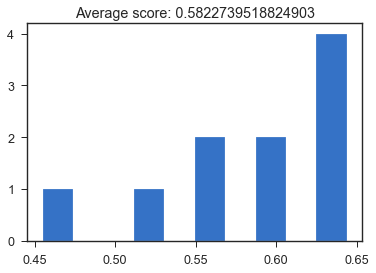

CPU times: user 147 ms, sys: 7.58 ms, total: 155 ms
Wall time: 2.7 s


In [109]:
%%time

# cross validation
cv_scores = cv_plotter(final_svm_doc, doc_combo, y)

- The final model appears to have some trouble generalizing, but averages out to a decent score.

In [110]:
%%time

# predict class for all poems
preds = final_svm_doc.predict(doc_combo)

# accuracy and f1 scores
acc = accuracy_score(y, preds)
f1 = f1_score(y, preds, average='weighted')

# print metrics, classification report, and confusion matrix
print(f'Accuracy: {acc}')
print(f'F1 score: {f1}')

print('\n' + '-' * 100 + '\n')

print(classification_report(y, 
                            preds, 
                            target_names=classes))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y, preds))

Accuracy: 0.6723937775713954
F1 score: 0.6689671878276241

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 Avant-Garde       0.60      0.65      0.62       955
Metropolitan       0.63      0.61      0.62      1071
      Modern       0.64      0.56      0.60      1244
    Pre-1900       0.81      0.90      0.85      1037

    accuracy                           0.67      4307
   macro avg       0.67      0.68      0.67      4307
weighted avg       0.67      0.67      0.67      4307


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[618 163 149  25]
 [210 652 167  42]
 [196 200 696 152]
 [ 13  16  78 930]]
CPU times: user 432 ms, sys: 47.4 ms, total: 479 ms
Wall time: 121 ms


#### Confusion matrix

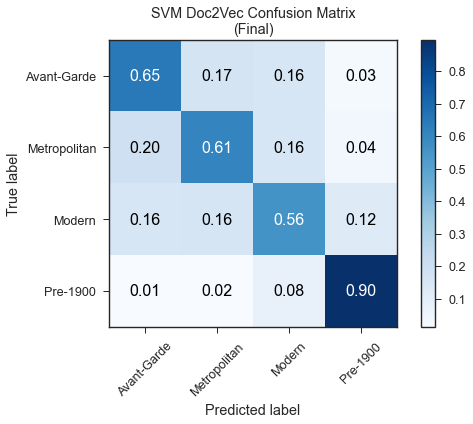

In [111]:
# confusion matrix with sklearn
cm = confusion_matrix(y, preds)

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM Doc2Vec Confusion Matrix\n(Final)',
    cmap=plt.cm.Blues)

# # # uncomment to save
# plt.savefig('charts/svm_doc_FINAL_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

- Everything other than Metropolitan improved! Avant-Garde and Modern improved quite a bit.
- An even more incredible score for Pre-1900 poetry.

#### Feature importances

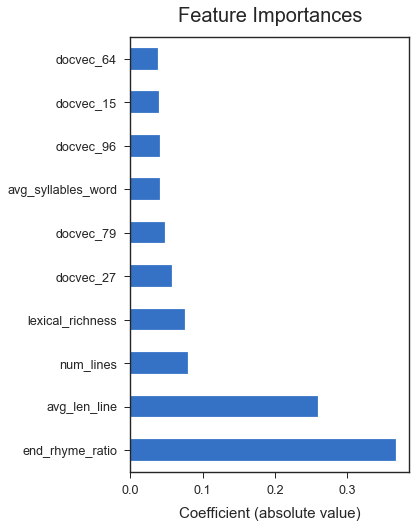

In [112]:
# top 10 features
svm_features(final_svm_doc, doc_combo.columns)

- Average number of syllables per word has returned!

#### 💾 Save/Load the final model

In [113]:
# # uncomment to save
# with gzip.open('data/final_model.pkl', 'wb') as goodbye:
#     pickle.dump(final_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/final_model.pkl', 'rb') as hello:
#     final_model = pickle.load(hello)

# Step 3: Reproducibility

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Below are the required packages and other information.

In [114]:
%load_ext watermark
%watermark -a 'Joshua Szymanowski' -nmv --packages numpy,pandas,sklearn,scipy,matplotlib,seaborn,wordcloud,nltk,gensim,vaderSentiment,textblob,pronouncing,pickle,gzip

Joshua Szymanowski Sat Aug 29 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.18.2
pandas 1.0.3
sklearn 0.0
scipy 1.4.1
matplotlib 3.2.1
seaborn 0.10.0
wordcloud 1.7.0
nltk 3.4.5
gensim 3.7.3
vaderSentiment 3.3.2
textblob 0.15.3
pronouncing 0.2.0
pickle unknown
gzip unknown

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


#### Running the cell below produces a finished model.

- To reproduce my final model, uncomment the line below reading ```model = Doc2Vec.load('data/d2v.model')```
- Note that this will still produce slightly different results given the randomness of inferring document vectors.

⏰ *NOTE: Next cell took me about 8 minutes to run.*

In [116]:
%%time

# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# text processing
from textblob import TextBlob
from vaderSentiment.vaderSentiment import \
    SentimentIntensityAnalyzer

# modeling
from sklearn.model_selection import train_test_split, \
    cross_val_score
from sklearn.preprocessing import MinMaxScaler, \
    StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, \
    classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# miscellany
import gzip
import pickle


# load dataframe
with gzip.open('data/poems_df_clean_trim.pkl', 'rb') as hello:
    df = pickle.load(hello)

#-----CREATE MOVEMENTS (TARGET CLASS)-----#
# sort genres into movements
conditions = [
    df.genre.isin(['romantic', 'victorian']),
    df.genre.isin([
        'beat', 'black_arts_movement', 'confessional', 
        'harlem_renaissance', 'new_york_school', 
        'new_york_school_2nd_generation'
    ]),
    df.genre.isin([
        'black_mountain', 'imagist', 'language_poetry', 
        'objectivist'
    ])
]
# name movements
choices = [
    'pre_1900',
    'metropolitan', 
    'avant_garde'
]
# convert data, leaving 'modern' untouched
df['movement'] = np.select(conditions, choices, df.genre)

print('Beginning feature engineering.')
#-----FEATURE ENGINEERING-----#
# remove numbers, section headers, and empty lines
df['clean_lines'] = df[['poem_lines', 'poet']].\
    apply(lambda x: line_cleaner(x.poem_lines, x.poet), axis=1)
# create number of lines column
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))
# create column using custom function
df['lines_titled'] = df[['title', 'clean_lines']].\
    apply(lambda x: titler(x.title, x.clean_lines), axis=1)
# create column using custom word counting function
df['num_words'] = df.lines_titled.apply(word_counter)
# create column of average number of words per line
df['avg_len_line'] = df.num_words / df.num_lines
# turn each titled poem into a string
df['string_titled'] = df.lines_titled.apply(
    lambda x: '\n'.join(x))
# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# create a column with the compound polarity score, 
# passing in the raw poem
df['sentiment_polarity_score'] = df['string_titled'].\
    apply(lambda x: analyzer.polarity_scores(x)['compound'])
# create a column with the compound polarity score, 
# passing in the raw poem to TextBlob
df['sentiment_subjectivity_score'] = df['string_titled'].\
    apply(lambda x: TextBlob(x).sentiment.subjectivity)
# run custom function to count the number of end rhymes in a poem
df['num_end_rhymes'] = df.clean_lines.apply(end_rhyme_counter)
# create column of the ratio of end rhymes to the total lines
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_lines
# divide number of syllables by number of words
df['avg_syllables_word'] = df.lines_titled.apply(
    syllable_counter) / df.num_words
# divide number of unique words by total words
df['lexical_richness'] = df.lines_titled.apply(
    unique_word_counter) / df.num_words
print('\tFeature engineering complete.')

print('\nBeginning to deal with outliers.')
#-----DEAL WITH OUTLIERS-----#
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])
df_capped['avg_syllables_word'] = winsorizer(
    df['avg_syllables_word'])
df_capped['lexical_richness'] = winsorizer(
    df['lexical_richness'])
df_capped['sentiment_subjectivity_score'] = winsorizer(
    df['sentiment_subjectivity_score'])
print('\tDealing with outliers complete.')

print('\nPreparing to model.')
#-----PREPARE FOR MODELING-----#
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness']
]
# lowercase text without punctuation and contractions
X['string_processed'] = df_capped.string_titled.apply(
    simple_process)
# assign target variable
y = df_capped['movement']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

# scale numerical data
# separate out numerical data
X_train_nums = X_train.drop(columns='string_processed')
X_test_nums = X_test.drop(columns='string_processed')
# instantiate scaler
scaler = StandardScaler()
# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)
# convert arrays to dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                                 columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                columns=X_test_nums.columns)
print('\tPreparing to model complete.')

print('\nPreparing document vectors.')
#-----PREPARE FOR DOC2VEC-----#
# list of words for each poem for both train and test sets
train_data = [poem.split() for poem in X_train.string_processed]
test_data = [poem.split() for poem in X_test.string_processed]
# prepare training data in doc2vec format
train_docs = [TaggedDocument((d), tags=[i]) \
              for i, d in enumerate(train_data)]

#-----CREATE DOCUMENT VECTORS-----#
# train a doc2vec model, using only training data
model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)
model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

#-----UNCOMMENT TO LOAD MY MODEL-----#
# model = Doc2Vec.load('data/d2v.model')

# infer in multiple steps to get a stable representation. 
train_vecs = [model.infer_vector(words, epochs=100) \
              for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) \
             for words in test_data]

# convert to dataframe
doc_train_vec = pd.DataFrame(train_vecs, columns=[
    f'docvec_{i}' for i in range(1,101)])
doc_test_vec = pd.DataFrame(test_vecs, columns=[
    f'docvec_{i}' for i in range(1,101)])

# combine with engineered features
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vec], 
                            axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vec], 
                           axis=1)
print('\tPreparing document vectors complete.')

print('\nRunning model.\n')
#-----RUN MODEL-----#
# instantiate the model
svm_doc_tuned = LinearSVC(C=0.0007, random_state=42)
# fit to the training set
svm_doc_tuned.fit(doc_train_combo, y_train)
# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc_tuned = \
    predict(svm_doc_tuned, doc_train_combo, y_train, 
            doc_test_combo, y_test, classes=sorted(y.unique()))

Beginning feature engineering.
	Feature engineering complete.

Beginning to deal with outliers.
	Dealing with outliers complete.

Preparing to model.
	Preparing to model complete.

Preparing document vectors.
	Preparing document vectors complete.

Running model.

-----TRAIN-----
Accuracy: 0.6715170278637771
F1 score: 0.668455665226983

-----TEST-----
Accuracy: 0.6332404828226555
F1 score: 0.6249435473799453

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

 avant_garde       0.61      0.49      0.54       239
metropolitan       0.55      0.66      0.60       268
      modern       0.60      0.49      0.54       311
    pre_1900       0.77      0.92      0.83       259

    accuracy                           0.63      1077
   macro avg       0.63      0.64      0.63      1077
weighted avg       0.63      0.63      0.62      1077


--------------------------------------------------

## Conclusions

[[go back to the top](#Song-Lyrics-Through-the-Years)]

My main takeaway is that poetry is a unique style of writing, in which form and structure (represented in this project by mostly numerical features) play a fairly significant role in categorizing into movements (and presumably on an even more micro-level into genres). Elements of form, such as the ratio of end rhymes to total lines, proportion of unique words (lexical richness), and the complexity of language (average syllables per word), played an important role in my final model. As did elements of style, such as the length of lines (measured by average words per line) and the length of the poem itself (measured by total lines).

Pre-1900 poetry is easily recognized. It tends to be longer poetry that uses a high number of end rhymes, a lot of words per line, and simpler words (fewer syllables per word). It also tends to be the most repetitious (low lexical richness score).

Avant-garde is the polar opposite. While similar to Metropolitan and Modern in terms of the number of lines, the number of words in a line is by far the lowest overall. It uses practically no end rhymes and tends to use more complex words (more syllables per word). It is also the most lexically rich movement.

Poetry is rarely neutral (and generally positive) and fairly equally subjective/objective. Pre-1900 poetry is overwhelmingly positive.

The vocabulary across movements was a mixture of visual, temporal, and ethereal words. Avant-Garde poetry tends to more frequently use visual and temporal terms (*see*, *light*, *eye*, *old*, *time*) whereas Pre-1900 poetry more often uses ethereal vocabulary (*god*, *heart*, *soul*, *world*). As with most other analyses, Modern and Metropolitan are somewhere in the middle.

In the future, it would be interesting to engineer even more features, such as other types of rhyming (use of internal rhymes or slant rhymes), verb tenses, and use of white space (i.e. whether a poem always starts on the left part of the line). Topic modeling may yield some interesting results as well. 

It may also be interesting to investigate the use of stop words across movements. In my experience in poetry classes, teachers strongly encourage one to use words that make up stop words very sparingly. Perhaps this is more of the influence of Avant-Garde movements on contemporary poetry, or does Avant-Garde poetry reject a long-established rule to use fewer stop words?

Also in the future, I plan on trying to build this out using the actual genres (of which there are 13), as opposed to the four umbrella-like movements that I used in order to explore, visualize, and model more easily. This will present some notable challenges, not least of which is the large class imbalance. Modern poetry, which is its own genre *and* movement, accounts for over a quarter of all the poems.

#### A brief note on modeling
Some endeavors were made into using Word2Vec within the LinearSVC model, as well as combining it with the Doc2Vec vectors. It showed promise but ultimately seemed too complicated without much additional gain. I also tried ensembling several models together, which I cut from this notebook for similar reasons. Finally, I tried an LSTM recurrent neural network model (using pre-trained word embeddings), which tended to only predict Modern and Pre-1900. As always, further tinkering could possibly improve this. Those attempts can be found in this [file](04_modeling-BACKUP_082820-wordvecs_NNs_before_simplifying.ipynb) in the archives.

I also tried an XGBoost model, which achieved a similar F1 score using the Doc2Vec combo data, but was too overfit. Those attempts can be found in this [file](04_modeling-BACKUP_082820-before_removing_xgb.ipynb) in the archives.


## Acknowledgements

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Thanks to the folks at [PoetryFoundation](https://www.poetryfoundation.org) for publishing poetry for well over a century and making this project possible.
- Thanks to [Sean Abu Wilson](https://github.com/seanabu) and [Fangfang Lee](https://github.com/jessicafangfanglee) for being great teachers.
- Thanks to [Allison Parrish](https://github.com/aparrish) for her [pronouncingpy](https://github.com/aparrish/pronouncingpy) package.
- Thanks to [Sanket Doshi](https://github.com/sdoshi579) for providing the basis for my contraction dictionaries.
- Thanks to [Bryan Bumgardner](https://bryanbumgardner.com/) for his old timey words list.
- Thank you to all the contributors of O'Reilly's [Practical Natural Language Processing repository](https://github.com/practical-nlp/practical-nlp).

- Finally, thanks to [Randal S. Olsen](http://www.randalolson.com/) for providing a great [example](https://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) of a machine learning notebook.


## Next notebook: [Recommendation System](05_recommendation_system.ipynb)

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- The next notebook includes building a content-based recommendation system using my final model from this notebook.